# Unet-2 

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

from model import UNET
from utils import (
    load_checkpoint,
    save_checkpoint,
    create_dataloaders,
    create_datasets,
    check_accuracy,
    get_mean_dice,
    show_three, 
)

import albumentations as A
from albumentations.pytorch import ToTensorV2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
import os
import numpy as np

def seed_everything(seed):
    # Фискирует максимум сидов.
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Model


In [3]:
def test():
    x = torch.randn((3, 1, 161, 161))
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam
    optimizer_params = [{"lr": 1e-4}]
    
    model = UNET(in_channels=1,
                 out_channels=1, 
                 loss_fn=loss_fn,
                 optimizer=optimizer,
                 optimizer_params=optimizer_params
                )
    
    preds = model(x)
    assert preds.shape == x.shape

test()

## Train part

1. Settings

In [4]:
# Hyperparameters etc.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_WORKERS = 2
IMAGE_HEIGHT = 256  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally

PIN_MEMORY = True
LOAD_MODEL = False
# 
MASKS = "/kaggle/input/stroke-aid-dataset-splitted/masks"
SLICES = "/kaggle/input/stroke-aid-dataset-splitted/slices"

2. Data augmentations

In [5]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A.Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

3. Let's create model

In [6]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam
optimizer_params = [{"lr": LEARNING_RATE}]

model = UNET(in_channels=3,
             out_channels=1, 
             loss_fn=loss_fn,
             optimizer=optimizer,
             optimizer_params=optimizer_params
            ).to(DEVICE)

                # WithLogits for making sigmoid   
                # or use torch.sigmoid() on the end of forward in model   
        
# scaler = torch.cuda.amp.GradScaler()

3. 1. If model has checkpoint

In [7]:
CHECKPOINT_NAME = "my_checkpoint.pth.tar"
if LOAD_MODEL:
    load_checkpoint(torch.load(CHECKPOINT_NAME), model)
    check_accuracy(val_loader, model, device=DEVICE)

4. Creating Loaders

In [8]:
train_dataset, val_dataset, test_dataset = create_datasets(MASKS, SLICES, train_transform)

train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)

Train size: 450
Valid size: 148
Test size:  149


5. Training itself

In [9]:
seed_everything(123456)
torch.cuda.empty_cache()

trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator=DEVICE,
    devices=1,
)

trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

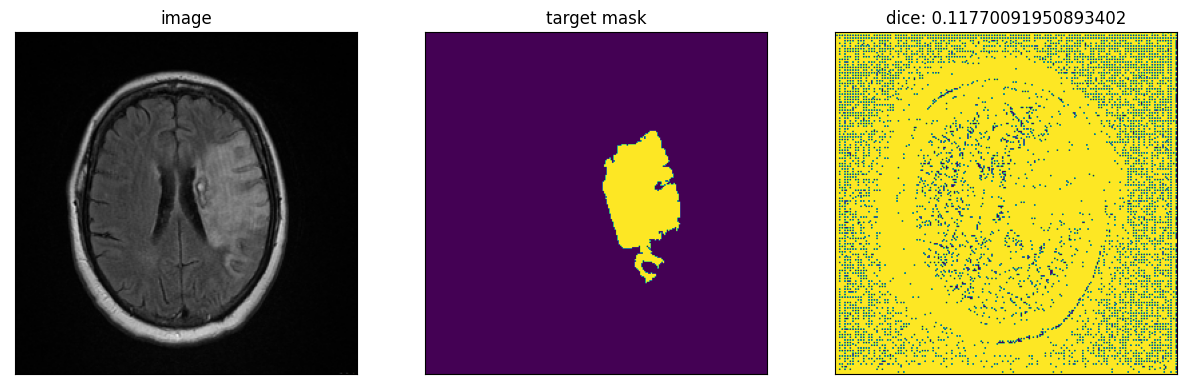

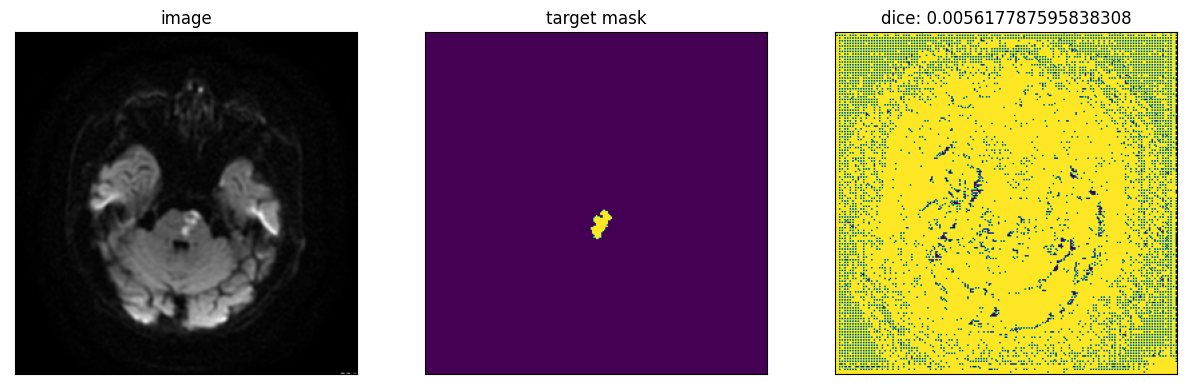

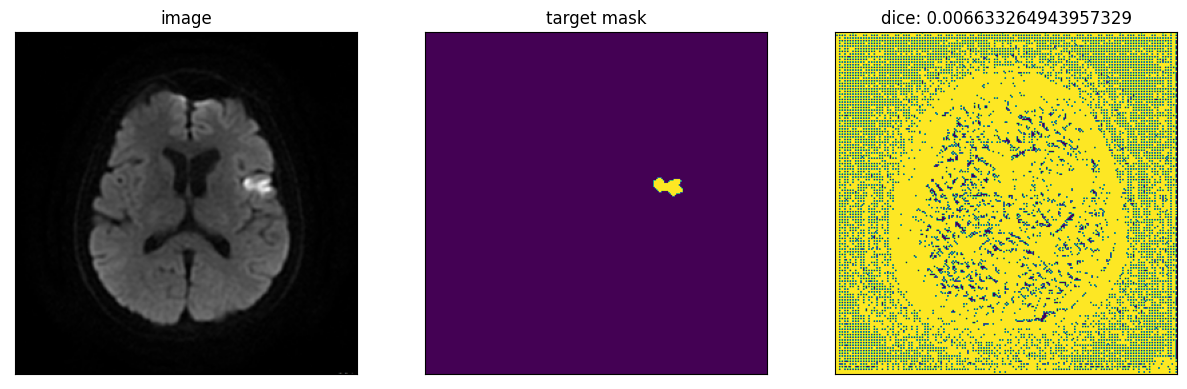

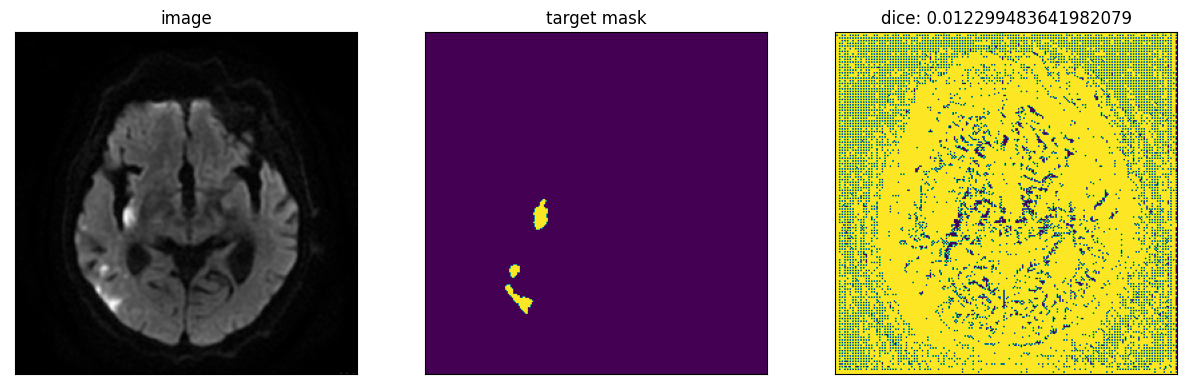

In [10]:
for i in range(4):
    image, target_mask = train_dataset[np.random.randint(0, 100)]
    show_three(model=model, 
               img_list=[(image, target_mask)], 
               device=DEVICE)

In [ ]:
predicted_dataset = get_predict(model=model,
                               image=test_dataset,
                               device=DEVICE)
get_mean_dice(test_dataset, predicted_dataset)
